In [7]:
from mlcolvar.cvs import MultiTaskCV
from mlcolvar.cvs import AutoEncoderCV
from mlcolvar.core.loss import TDALoss

import torch
#torch.set_default_dtype(torch.float32)
# Set seed for reproducibility
torch.manual_seed(42)

In [20]:
import numpy as np

l = np.loadtxt('ts_data/all_data')
np.savetxt('combined', l , fmt='%0.4f')

min1=np.loadtxt('../metad_guess/COLVAR_min1')
np.savetxt('COLVAR_min1_new',min1[::1000],fmt='%0.4f')

min2=np.loadtxt('../metad_guess/COLVAR_min2')
np.savetxt('COLVAR_min2_new',min2[::1000],fmt='%0.4f')

! cat COLVAR_min1_new combined COLVAR_min2_new > combined_new 
!  echo -e "#! FIELDS time p.x p.y p.z mueller path_s path_z\n$(cat COLVAR_min1_new)" > COLVAR_min1_new
!  echo -e "#! FIELDS time p.x p.y p.z mueller path_s path_z\n$(cat COLVAR_min2_new)" > COLVAR_min2_new
!  echo -e "#! FIELDS time p.x p.y p.z mueller path_s path_z\n$(cat combined_new)" > combined_new

In [21]:
from mlcolvar.data import DictModule
from mlcolvar.core.transform import Normalization
from mlcolvar.core.transform.utils import Statistics
from mlcolvar.utils.fes import compute_fes
from mlcolvar.utils.io import create_dataset_from_files, load_dataframe
from mlcolvar.utils.plot import muller_brown_potential_three_states, plot_isolines_2D, plot_metrics, paletteFessa
from mlcolvar.utils.trainer import MetricsCallback

# load unlabeled data
filenames = [ "combined_new"]
path_dataset, path_df = create_dataset_from_files(filenames, return_dataframe=True,
                                                  filter_args={'regex':'p.x|p.y'}, verbose=False, stride=1)

# load labeled data
filenames = [ "COLVAR_min1_new" , "COLVAR_min2_new" ]
state_dataset, state_df = create_dataset_from_files(filenames,return_dataframe=True,
                                                    filter_args={'regex':'p.x|p.y'}, verbose=False, stride=1)

# create multitask datamodule with both datasets
datamodule = DictModule(dataset=[path_dataset, state_dataset])
datamodule

DictModule(dataset -> [DictDataset( "data": [14871, 2] ), DictDataset( "data": [4002, 2], "labels": [4002] )],
		     train_loader -> DictLoader(length=0.8, batch_size=0, shuffle=True),
		     valid_loader -> DictLoader(length=0.2, batch_size=0, shuffle=True))

In [22]:
import torch

class AutoencoderPath(AutoEncoderCV):
  def __init__(self,**kwargs):
    super().__init__(**kwargs)

  def forward(self,x):
    s = super().forward(x)
    x_hat = super().encode_decode(x)
    loss = torch.nn.MSELoss(reduction='none') 
    z = torch.linalg.norm(loss(x,x_hat) , dim=-1)
    return torch.hstack([s,z.unsqueeze(dim=-1)])


In [23]:
n_states=2

nn_args = {'activation': 'shifted_softplus'}
options= {'encoder': nn_args, 'decoder': nn_args }

main_cv = AutoencoderPath(encoder_layers=[2,10,10,1] , options=options)
aux_loss_fn = TDALoss(n_states, [-5, 5], [0.2, 0.2])
model = MultiTaskCV(main_cv, auxiliary_loss_fns=[aux_loss_fn], loss_coefficients=[5e-3])

stat = Statistics()
stat(path_dataset['data'])
stat(state_dataset['data'])
model.norm_in.set_from_stats(stat)
#model = model.float(); model.to("mps")

model.optimizer_kwargs = {'weight_decay' : 1e-8, 'lr' : 5e-3 }
#model.optimizer_kwargs = {'lr' : 1e-2 }
#model.to('cpu')
model

MultiTaskAutoencoderPath(
  (loss_fn): MSELoss()
  (norm_in): Normalization(in_features=2, out_features=2, mode=mean_std)
  (encoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (decoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=10, out_features=2, bias=True)
    )
  )
  (auxiliary_loss_fns): ModuleList(
    (0): TDALoss()
  )
)

In [24]:
from lightning import Trainer
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_total_loss", patience=20, min_delta=1e-3)

# define trainer
trainer = Trainer(callbacks=[metrics, early_stopping], logger=None, enable_checkpointing=False, max_epochs=500)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [25]:
torch.set_float32_matmul_precision('medium')
#device = torch.device("cpu")
trainer.fit( model, datamodule )

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type          | Params | Mode  | In sizes | Out sizes
------------------------------------------------------------------------------------
0 | loss_fn            | MSELoss       | 0      | train | ?        | ?        
1 | norm_in            | Normalization | 0      | train | [2]      | [2]      
2 | encoder            | FeedForward   | 151    | train | [2]      | [1]      
3 | decoder            | FeedForward   | 152    | train | [1]      | [2]      
4 | auxiliary_loss_fns | ModuleList    | 0      | train | ?        | ?        
------------------------------------------------------------------------------------
303       Trainable params
0         Non-trainable params
303       Total params
0.001     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/home/revanth/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2974. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/revanth/.local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

/home/revanth/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 11897. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

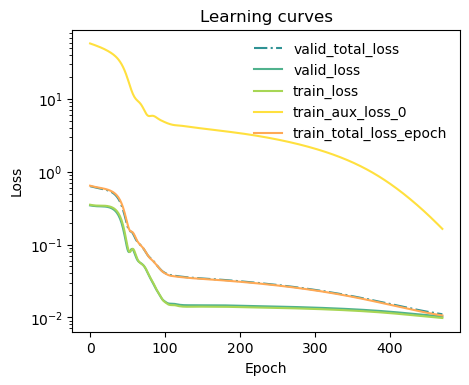

In [27]:
from mlcolvar.utils.plot import plot_metrics

ax = plot_metrics(metrics.metrics,
                  keys=['valid_total_loss','valid_loss','train_loss', 'train_aux_loss_0', 'train_total_loss_epoch'],
                  linestyles=['-.','-','-','-','-'], colors=['fessa1','fessa2','fessa3','fessa4','fessa5'],
                  yscale='log')

In [28]:
decoder = model.get_decoder(return_normalization=True)

In [29]:
X = path_dataset[:]['data']
with torch.no_grad():
    model.postprocessing = None # reset
    s = model(torch.Tensor(X))
s_np = s.numpy()
print(s_np.max(),s_np.min())

5.280125 -5.337984


In [30]:
xx = torch.linspace(-5,5,10).unsqueeze(1)
#yy = torch.linspace(-5,5,10).unsqueeze(0)
xy_gen = decoder(xx).detach().numpy()

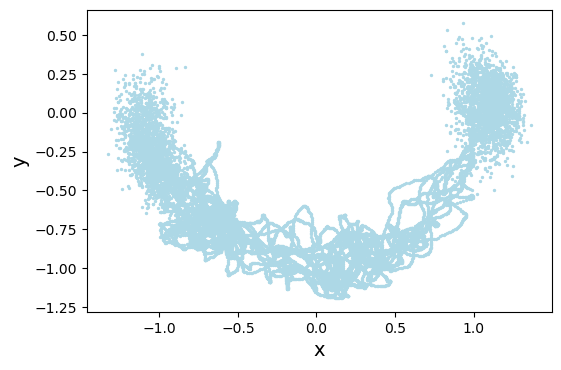

In [32]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,4),dpi=100)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)

p_x = path_df[['p.x']].values
p_y = path_df[['p.y']].values

#plot training data
l = np.loadtxt('combined_new')
plt.scatter(l[::1,1],l[::1,2],c='lightblue',s=2)
#plt.plot(p_x[indices],p_y[indices],c='k')
#plt.scatter(p_x[indices],p_y[indices],c='k',marker='o')
#plt.savefig('pcv_round1.png',dpi=200,bbox_inches='tight')

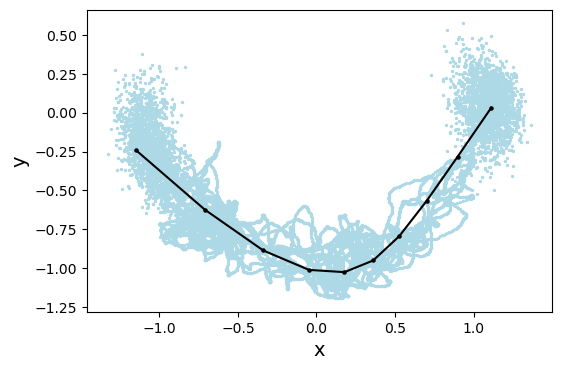

In [33]:
plt.figure(figsize=(6,4),dpi=100)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)

p_x = path_df[['p.x']].values
p_y = path_df[['p.y']].values

#plot training data
l = np.loadtxt('combined_new')
plt.scatter(l[::1,1],l[::1,2],c='lightblue',s=2)
plt.plot(xy_gen[:,0],xy_gen[:,1],c='k')
plt.scatter(xy_gen[:,0],xy_gen[:,1],c='k',s=5)
#plt.scatter(p_x[indices],p_y[indices],c='k',marker='o')
#plt.savefig('pcv_round1.png',dpi=200,bbox_inches='tight')

In [16]:
"""s = 2/3
theta=np.column_stack((p_x[indices],p_y[indices])) 
theta_new = []
theta_new.append(theta[0])
for i in range(1,len(theta)-1):
    theta_new.append((1-s)*theta[i]+s*((theta[i-1]+theta[i+1])/2))
    #print(theta_new)
theta_new.append(theta[-1])
theta_new = np.array(theta_new)""""

[[-1.0533     -0.3411    ]
 [-0.82303333 -0.04933333]
 [-0.6011      0.14893333]
 [-0.44366667  0.38086667]
 [-0.32426667  0.68546667]
 [-0.16296667  0.89306667]
 [ 0.1204      0.85733333]
 [ 0.45843333  0.7174    ]
 [ 0.83876667  0.43066667]
 [ 1.2374      0.0163    ]]


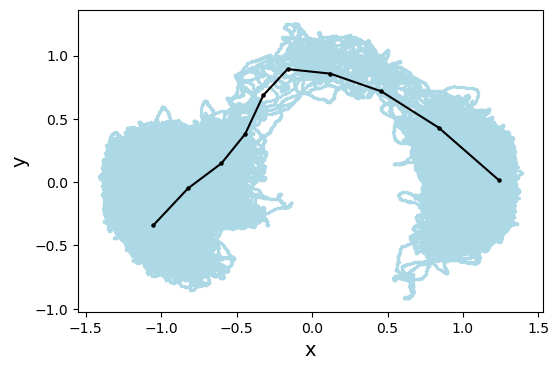

In [17]:
""""plt.figure(figsize=(6,4),dpi=100)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.scatter(l[::1,1],l[::1,2],c='lightblue',s=2)
plt.plot(theta_new[:,0],theta_new[:,1],c='k')
plt.scatter(theta_new[:,0],theta_new[:,1],c='k',marker='o',s=5)
print(theta_new)""""

In [34]:
print(xy_gen)

[[-1.1473676  -0.2428087 ]
 [-0.7100862  -0.6242731 ]
 [-0.33857104 -0.88647246]
 [-0.04727925 -1.011457  ]
 [ 0.17828985 -1.0257922 ]
 [ 0.36075807 -0.95094097]
 [ 0.5268713  -0.7946397 ]
 [ 0.70227253 -0.56631386]
 [ 0.8981614  -0.2838847 ]
 [ 1.1126553   0.03182226]]


In [35]:
model.to_torchscript(file_path="multitask_round_1.ptc", method="trace")

/home/revanth/.local/lib/python3.10/site-packages/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


MultiTaskAutoencoderPath(
  original_name=MultiTaskAutoencoderPath
  (loss_fn): MSELoss(original_name=MSELoss)
  (norm_in): Normalization(original_name=Normalization)
  (encoder): FeedForward(
    original_name=FeedForward
    (nn): Sequential(
      original_name=Sequential
      (0): Linear(original_name=Linear)
      (1): Shifted_Softplus(original_name=Shifted_Softplus)
      (2): Linear(original_name=Linear)
      (3): Shifted_Softplus(original_name=Shifted_Softplus)
      (4): Linear(original_name=Linear)
    )
  )
  (decoder): FeedForward(
    original_name=FeedForward
    (nn): Sequential(
      original_name=Sequential
      (0): Linear(original_name=Linear)
      (1): Shifted_Softplus(original_name=Shifted_Softplus)
      (2): Linear(original_name=Linear)
      (3): Shifted_Softplus(original_name=Shifted_Softplus)
      (4): Linear(original_name=Linear)
    )
  )
  (auxiliary_loss_fns): ModuleList(
    original_name=ModuleList
    (0): TDALoss(original_name=TDALoss)
  )
)